#  CLIP Zero-Shot Classification Playground

In this notebook, we explore the capabilities of OpenAI's **CLIP (Contrastive Language-Image Pre-training)** model. Unlike traditional classification models trained on fixed labels, CLIP can understand the semantic relationship between images and free-form text.

### Objectives
1. **Object Recognition**: Identify objects in images using natural language.
2. **Style Analysis**: Distinguish between art styles (e.g., Cyberpunk vs. Sketch).
3. **Sentiment Analysis**: Detect emotions or vibes in a photo.

---
### Step 1: Setup & Imports
Initialize the environment, setup paths, and import necessary libraries for image processing and visualization.

In [1]:
import os
import sys
import torch

from PIL import Image
import matplotlib.pyplot as plt

current_dir = os.getcwd()
project_root = os.path.dirname(current_dir)

if project_root not in  sys.path:
    sys.path.append(project_root)

from utils.model_loader import load_clip_model

%matplotlib inline
plt.style.use('ggplot')

### Step 2: Load CLIP Model

Here we initialize the CLIP model using our custom loader. 

* **Model**: We are using the `huge` variant (`laion2b`), which has ~1B parameters for state-of-the-art performance.
* **Optimization**: `use_fp16=True` is enabled to utilize Mixed Precision, significantly reducing memory usage and speeding up inference on modern GPUs (like the RTX 4070).


In [2]:
MODEL_NAME = "huge" # optional: "base", "large", "huge"

print(f"initialization {MODEL_NAME}...")
model, processor, device = load_clip_model(MODEL_NAME, use_fp16=True)

print(f"device: {device}")

initialization huge...
[ModelLoader] loading: huge (cuda)
loading success! (FP16=True)
device: cuda


### Step 3: Define Experiment Logic

We define the `run_experiment` function to handle the end-to-end zero-shot classification process:

1. **Input**: Loads an image from the local `assets/` directory.
2. **Preprocessing**: Converts the image and text prompts into tensors.
3. **Inference**: Calculates the cosine similarity between the image and the text descriptions.
4. **Visualization**: Displays the source image alongside the predicted probability distribution.

In [3]:
def run_experiment(filename, text_prompts):
    """
    Args:
        filename: assets/file_name
        text_prompts: label list
    
    """
    image_path = os.path.join(project_root, "assets", filename)
    if not os.path.exists(image_path):
        print(f"can not find that image: {image_path}")
        print("first execute: python scripts/prepare_assets.py")
        return

    image = Image.open(image_path).convert("RGB")

    inputs = processor(
        text=text_prompts,
        images=image,
        return_tensors="pt",
        padding=True,
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=1).cpu().numpy()[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(filename)

    results = list(zip(text_prompts, probs))
    results.sort(key=lambda x: x[1], reverse=False)
    labels, scores = zip(*results)

    colors = ['gray' if s < max(scores) else 'crimson' for s in scores]
    ax2.barh(labels, scores, color=colors)
    ax2.set_xlim(0, 1.0)
    ax2.set_title("CLIP Zero-Shot Prediction")

    plt.tight_layout()
    plt.show()

### Step 4: Let's Experiment!

Now that everything is set up, let's run some zero-shot classification tests.

#### Scenario A: Object Identification
Is it a cat or a dog?

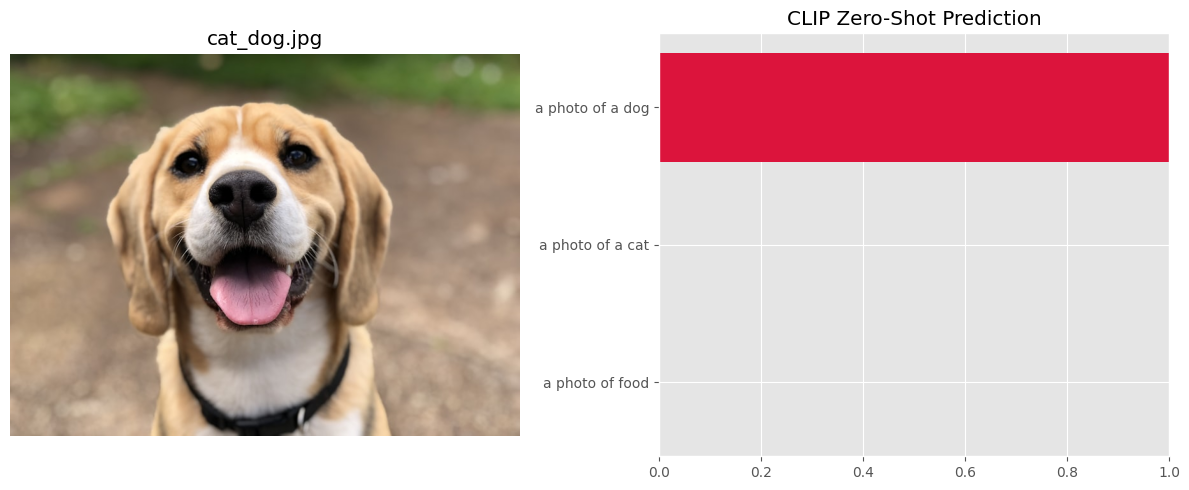

In [4]:
run_experiment("cat_dog.jpg", ["a photo of a cat", "a photo of a dog", "a photo of food"])

#### Scenario B: Art Style Analysis
Testing CLIP's ability to understand artistic concepts (e.g., Cyberpunk, Oil Painting).

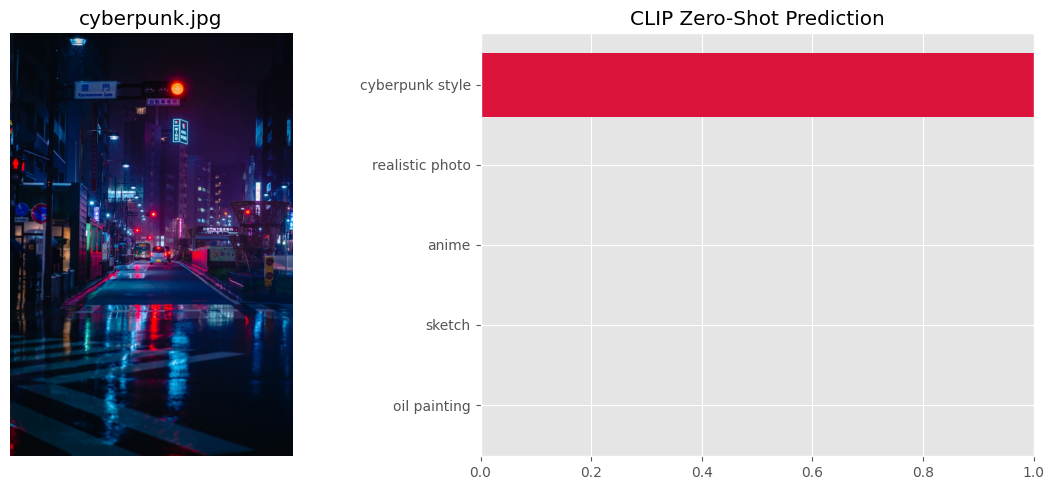

In [5]:
run_experiment("cyberpunk.jpg", ["cyberpunk style", "oil painting","sketch", "anime", "realistic photo"])

#### Scenario C: Emotion & Vibe Check
Analyzing the sentiment or atmosphere of an image.

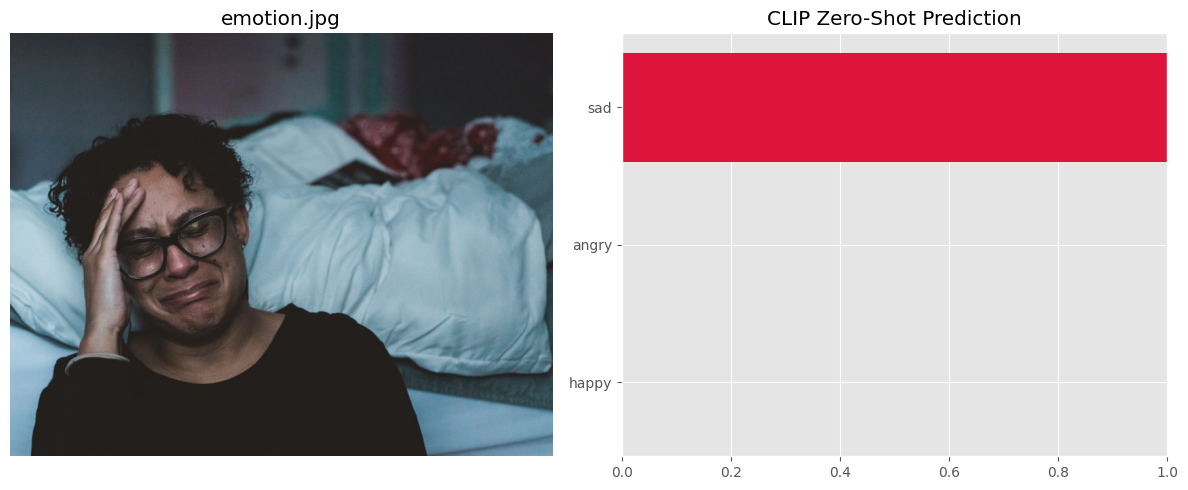

In [9]:
run_experiment("emotion.jpg", ["happy", "sad", "angry"])

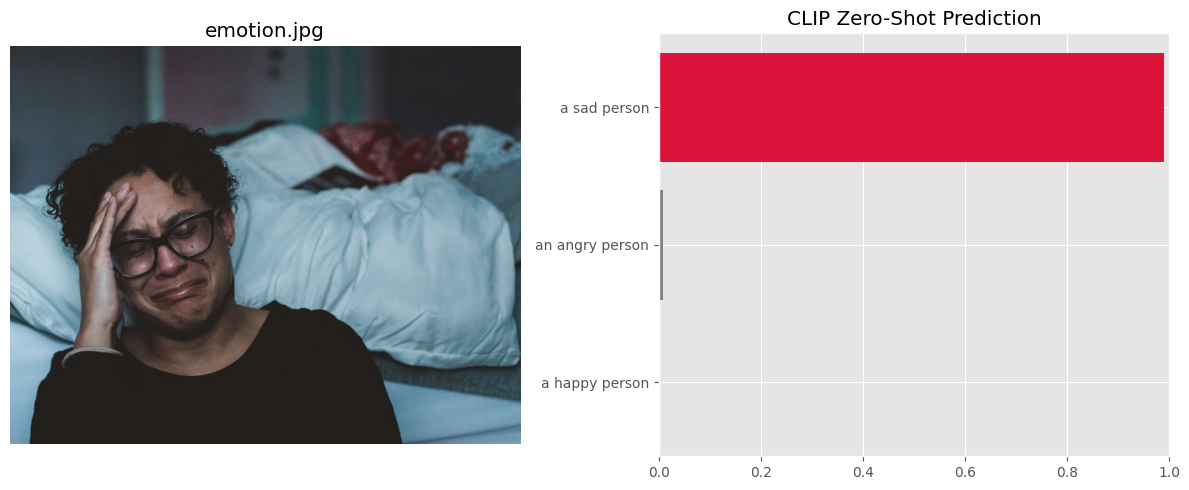

In [10]:
run_experiment("emotion.jpg", ["a happy person", "a sad person", "an angry person"])

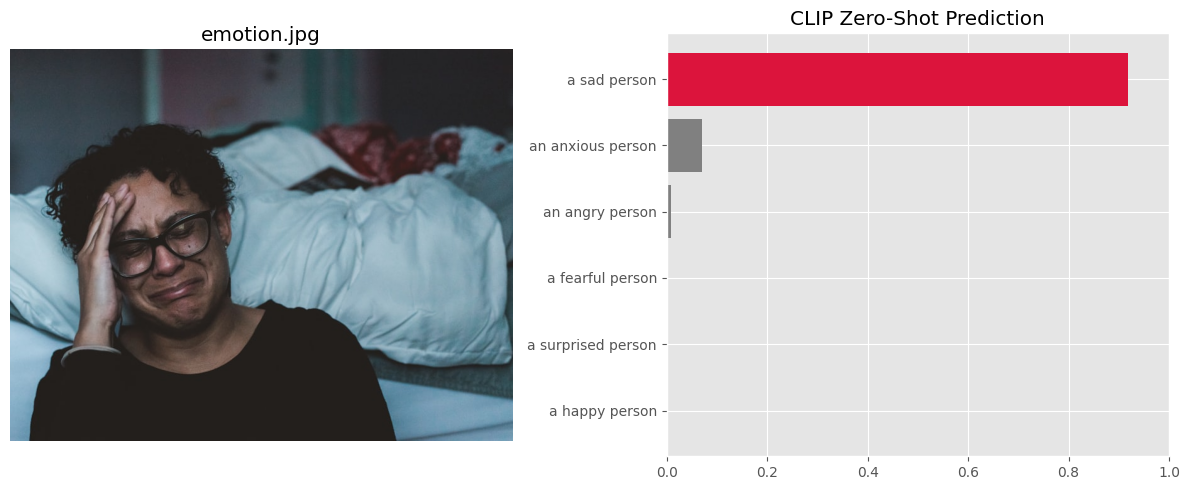

In [6]:
run_experiment("emotion.jpg", ["a happy person", "a sad person", "an angry person", "a surprised person", "a fearful person", "an anxious person"])

#### Scenario D: Semantic Depth Test

We use an image of a **Chinese red envelop (Hongbao)** to test if CLIP understands the *semantics* (meaning/function) of an object byond its physical appearance.

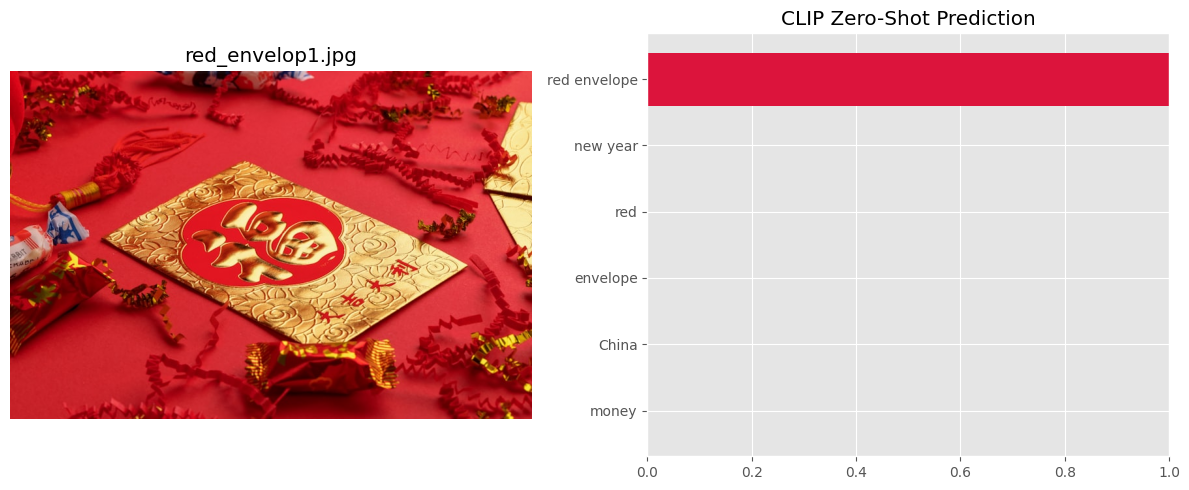

In [24]:
run_experiment("red_envelop1.jpg", ["money", "new year", "red", "envelope", "red envelope", "China"])

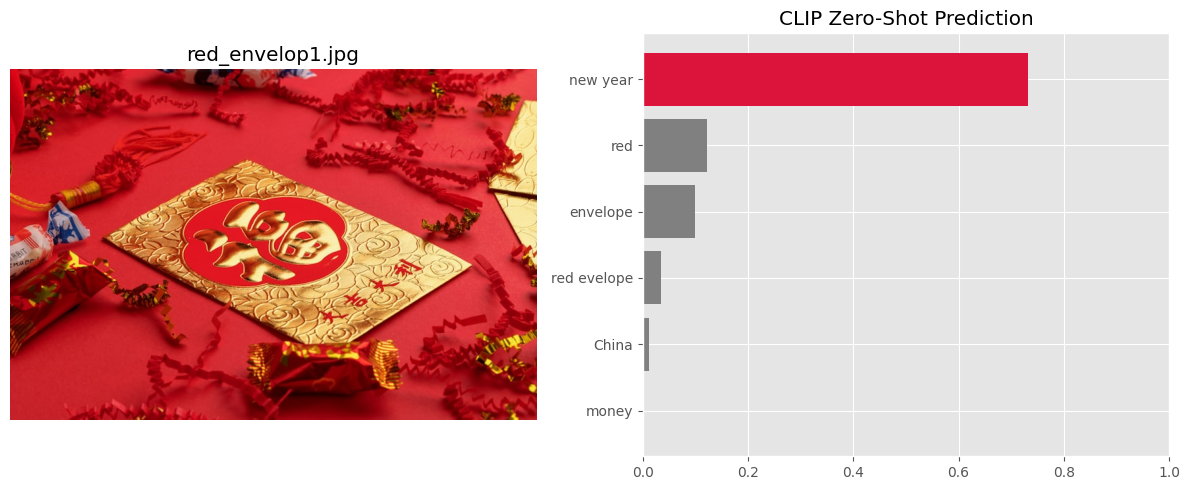

In [25]:
run_experiment("red_envelop1.jpg", ["money", "new year", "red", "envelope", "red evelope", "China"])